# Proyecto de predicción de resultados partidas PUBG - 1ra entrega

![image info](https://assets.goal.com/v3/assets/bltcc7a7ffd2fbf71f5/bltef3283334c7a2677/60de056d2446e93b5b6c87d6/8d9c326c1ca413195b04107a072c6e81a27962e0.jpg)

**Introducción.** El Players Unknown Battlegrounds (PUBG de aqui en adelante) es un videojuego disponible para varias consolas (PC, PS4, PS5, Xbox y móviles) de los denominados battle royale, que puede jugarse en primera o tercera persona. Hasta 100 jugadores saltan en paracaidas de un avion en algun momento de su recorrido, aterrizando en un mapa completamente desequipados. A partir de allí buscaran equiparse lo mejor que puedan con armas, municiones, miras, consumibles; teniendo como objetivo final matar al resto de los jugadores y ser los ultimos en pie. La partida puede jugarse solo o en modo coperativo, y la zona de mapa habitable se va cerrando con el paso del tiempo forzando asi encuentros entre jugadores.

**Contexto empresarial.** Un sitio de apuestas online desea incluir entre sus eventos de apuesta, las partidas del torneo 'PUBG Global Championship'. Para ello, requieren poder predecir el resultado de las mismas, de manera que luego ellos puedan calcular las cuotas deportivas y los favoritos a ganar cada fase (y ajustar las mismas conforme esta se vaya desarrollando); tomando apuestas de acuerdo a esta información.

**Problema comercial.** Su tarea consistirá en predecir el resultado de una partida.

**Contexto analítico.** Se ha recopilado un conjunto de datos con resultados de partidas y sus correspondientes estadísticas, para jugadores de diverso nivel. El mismo posee métricas como asistencias, distancia recorrida a pie, en vehículos, daño inflingido, etc. y por supuesto ranking final en la partida.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [ ]:
# link_de_dropbox = https://www.dropbox.com/s/xolfzp90j093scn/PUBG%20results.csv?dl=0

url = "https://www.dropbox.com/s/xolfzp90j093scn/PUBG%20results.csv?dl=1"

PUBG = pd.read_csv(url)
PUBG.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [ ]:
PUBG.shape

(4446966, 29)

In [ ]:
PUBG.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'],
      dtype='object')

**Columnas**

* *Id:* Id del jugador
* *groupId:* Id de un grupo de jugadores (modo coperativo). Si el mismo grupo juega una partida diferente, este Id varía.
* *matchId:* Id de la partida.	
* *assists:* Numero de jugadores enemigos que fueron dañados por el jugador y posteriormente muertos por un compañero.
* *boosts:* Cantidad de items de boost utilizados. 
* *damageDealt:* Daño inflingido a enemigos.
* *DBNOs:* Numero de enemigos knockeados. Nota: todo jugador que reciba un daño considerable pero no fatal se considera knockeado; en este estado solo podrá arrastrarse y podrá ser revivido por un compañero.
* *headshotKills:* Cantidad de enemigos muertos por disparos a la cabeza.
* *heals:* Cantidad de items de curación utilizados.
* *killPlace:* Ranking en cuanto a cantidad de enemigos matados.
* *killPoints:* Ranking externo a la partida en cuanto a cantidad de enemigos matados (una especie de Elo de muertes).
* *kills:* Cantidad de enemigos matados.
* *killStreaks:* Cantidad de enemigos matados en un corto periodo de tiempo (racha de muertes).
* *longestKill:* Mayor distancia entre un enemigo matado y el jugador al momento de su muerte. Nota: puede ser engañoso ya que un enemigo knockeado morirá desangrado si no lo reviven.
* *matchDuration:* Duracion de la partida en s.
* *matchType:* Tipo de partida, puede ser “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp” y “squad-fpp”'. Las variantes fpp solo se pueden jugar en primera persona.
* *maxPlace:* Peor ranking para el que se tiene data en la partida. Nota: puede no coincidir con la data de 'numGroups', ya que a veces se saltea rankings.
* *numGroups:* Número de grupos en la partida.
* *rankPoints:* Ranking simil Elo del jugador.
* *revives:* Número de compañeros revividos por el jugador.
* *rideDistance:* Distancia recorrida por el jugador en vehículos medida en m.
* *roadKills:* Número de enemigos matados desde un vehículo.
* *swimDistance:* Distancia nadada por el jugador medida en m.
* *teamKills:* Número de compañeros de equipo muertos por el jugador.
* *vehicleDestroys:* Número de vehículos destruidos.
* *walkDistance:* Distancia recorrida por el jugador a pie medida en m.
* *weaponsAcquired:* Cantidad armas levantadas.
* *winPoints:* Ranking externo del jugador en cuanto a cantidad de victorias.
* *winPlacePerc:* Objetivo de la predicción. Es un percentil que indica el ranking en la partida; 1 significa primero y 0 última posición.

# Hipótesis

El objetivo será entonces predecir las posiciones finales en la partida. Para ello estudiaremos la influencia que métricas como enemigos matados o daño inflingido tienen en el resultado de la partida; ya que con estrategias de confrontación si bien puedo llegar a eliminar contrincantes para luego tomar su equipamiento, también da a conocer nuestra posición por el sonido de los disparos a otros enemigos. Quizas una estrategia de sigilo sea mas adecuada. 

También puede estudiarse el factor suerte, de que el mapa cierre alrededor de mi zona de aterrizaje; en este caso las distancias recorridas (ya sea a pie o en vehículos serán menores).

En los casos mencionados, se observan diferencias destacables de los mejores jugadores respecto al resto?

# EDA

In [ ]:
PUBG.isna().sum()
# Se observa que el df esta en muy buen estado, con un solo valor faltante.

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

In [ ]:
PUBG.dropna(subset='winPlacePerc', inplace=True)  
PUBG.isna().sum() 
# Teniendo mas de 4M de filas, podemos eliminar esa fila con valor faltante

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       0
dtype: int64

In [ ]:
PUBG.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4446965 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

Se observan que los identificadores de jugador, grupo, partida y tipo de partida son cadenas de texto. Los primeros 3 podemos descartarlos ya que no nos suman información relevante para nuestro análisis, pero el último debemos convertirlo en categorias numéricas para poder utilizarlas en el modelo de predicción mas adelante.

In [ ]:
PUBG['matchType'] = PUBG['matchType'].astype('category')
PUBG['matchType'] = PUBG['matchType'].cat.codes
# Se convierten los tipos de partida de strings a categorias numéricas para poder aplicar luego algún método de regresión

In [ ]:
PUBG.drop(labels=['Id',	'groupId', 'matchId'], axis=1, inplace=True)
# Eliminamos los identificadores de jugador, equipo y partida

In [ ]:
PUBG.shape

(4446965, 26)

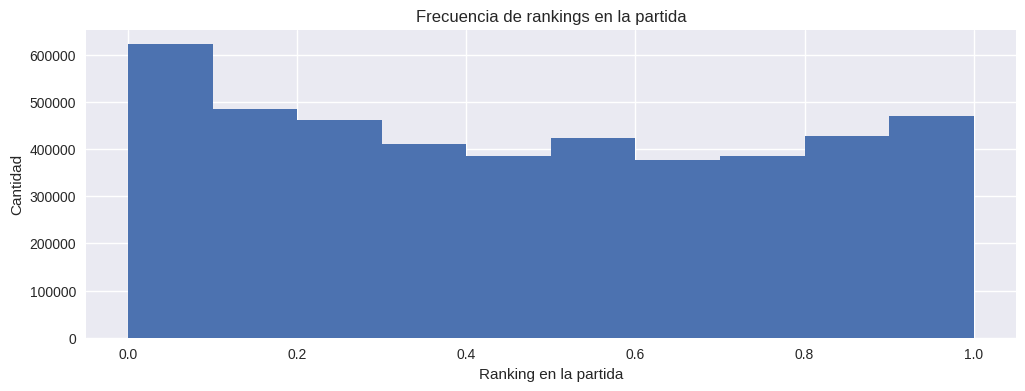

In [ ]:
mpl.style.use('seaborn-v0_8') 

plt.figure(figsize=(12, 4))
plt.hist(PUBG.winPlacePerc)
plt.xlabel('Ranking en la partida')
plt.title('Frecuencia de rankings en la partida')
plt.ylabel('Cantidad')
plt.show()

En primer lugar inspeccionamos la distribución de valores de nuestra variable objetivo -winPlacePerc-. Si bien esta no es completamente uniforme, si contamos con una cantidad mas que importante de toda la gama de valores.

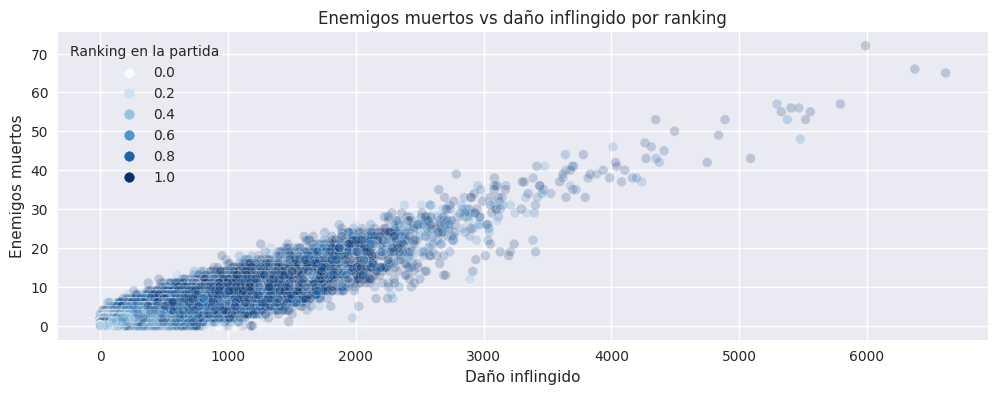

In [ ]:
sns.set_style("darkgrid")

plt.figure(figsize=(12, 4))
sns.scatterplot(data=PUBG, x='damageDealt', y='kills', 
                alpha=.2, 
                hue='winPlacePerc',
                palette='Blues')
plt.xlabel('Daño inflingido')
plt.ylabel('Enemigos muertos')
plt.title('Enemigos muertos vs daño inflingido por ranking')
plt.legend(title='Ranking en la partida')
plt.show()

Se observa una fuerte correlacion entre daño inflingido y cantidad de enemigos muertos, aunque esto no necesariamente se traduce en un mejor ranking en la partida.

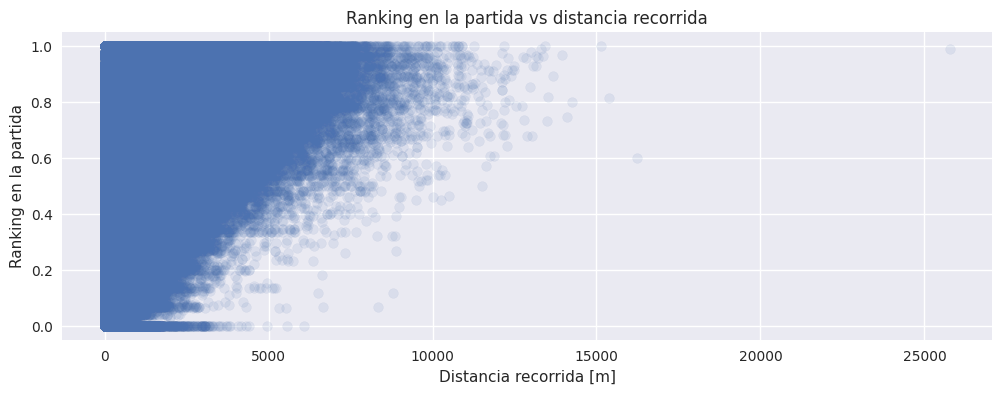

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
ax.scatter(PUBG.walkDistance, PUBG.winPlacePerc, 
           alpha=.1)
ax.set_xlabel('Distancia recorrida [m]')
ax.set_ylabel('Ranking en la partida')
ax.set_title('Ranking en la partida vs distancia recorrida')
plt.show()

Se observa que los jugadores que mejor ranking obtienen en la partida, tienden a recorrer mayores distancias en promedio; lo que en principio implica mayor estrategia y menor factor suerte (el mapa cerrando alrededor de mi posición de aterrizaje).

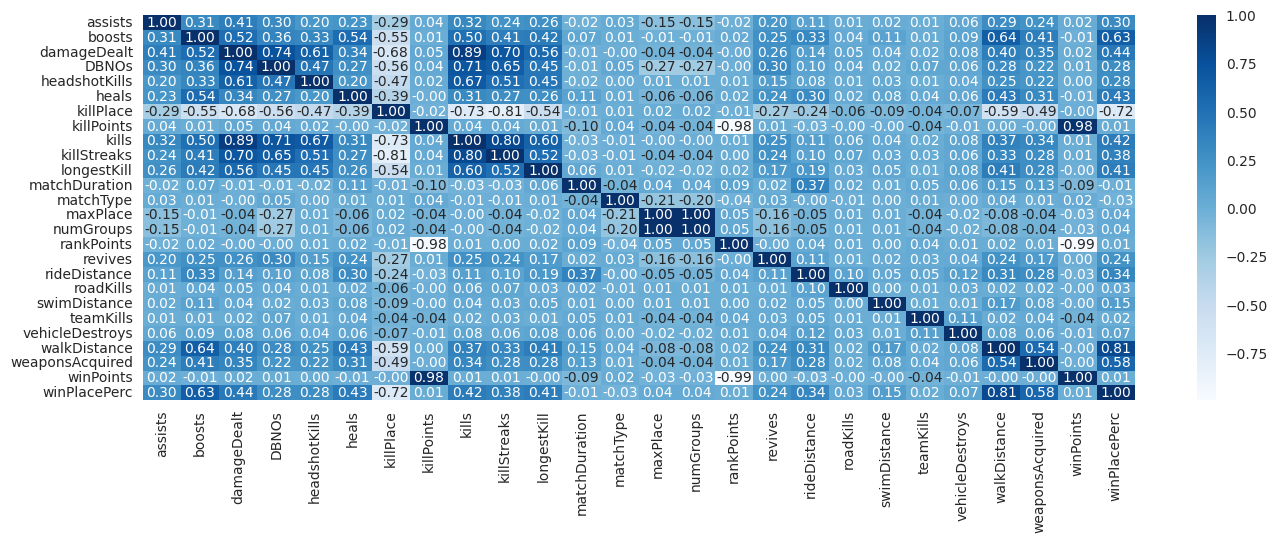

In [ ]:
plt.figure(figsize=(16, 5))
sns.heatmap(PUBG.corr(), cmap='Blues', annot=True, fmt='.2f')
plt.show()

Graficando la matriz de correlación, podemos observar cuales son las variables que más influyen sobre el ranking obtenido en la partida; siendo estas en orden creciente: la cantidad de armas adquiridas, la cantidad de ‘boosts’ utilizados, el ‘killPlace’ (ranking en cuanto a enemigos matados, el cual tiene una correlación negativa) y por ultimo ‘walkDistance’ o distancia recorrida a pie.

Respecto a la cantidad de armas adquiridas, es lógico pensar que un jugador vaya cambiando por otras mejores conforme vaya avanzando la partida.

Los boosts proveen una ventaja temporal al jugador, otorgando velocidad de movimiento aumentada y regeneración de vida durante cierto periodo de tiempo. Realizaremos a continuación algunos gráficos estudiando si existen diferencias en la distribución de boosts utilizados, comparándolos con el 10% de mejores jugadores y calculando también si hay variacion en la cantidad media utilizada por ambos grupos.

El killplace o ranking por enemigos matados posee una correlación alta y negativa con el ranking en la partida; esto se da ya que la escala va de 1 (mayor cantidad de asesinatos) a 100 (menor cantidad de asesinatos), la cual es inversa a la de la variable objetivo que va de 0 a 1. Esto tiene lógica ya que un jugador habilidoso tiende a eliminar mayor cantidad de enemigos y posee una mayor probabilidad de ganar la partida. De vuelta podemos comparar el valor del general contra el 10% de mejores jugadores.

Por último, hay una alta correlación (la mas alta entre las variables independientes y mi variable objetivo) entre walkDistance -distancia recorrida a pie- y ranking en la partida. Esto descarta la hipotesis inicial de la suerte de que el mapa vaya cerrando alrededor de mi posición inicial y en cambio refuerza la idea del reposicionamiento constante.

Nos concentraremos en estas 4 variables para el analisis.

### Armas adquiridas

In [ ]:
top10 = PUBG.query('winPlacePerc >= .9')
# Se recorta al conjunto de mejores 10% de jugadores

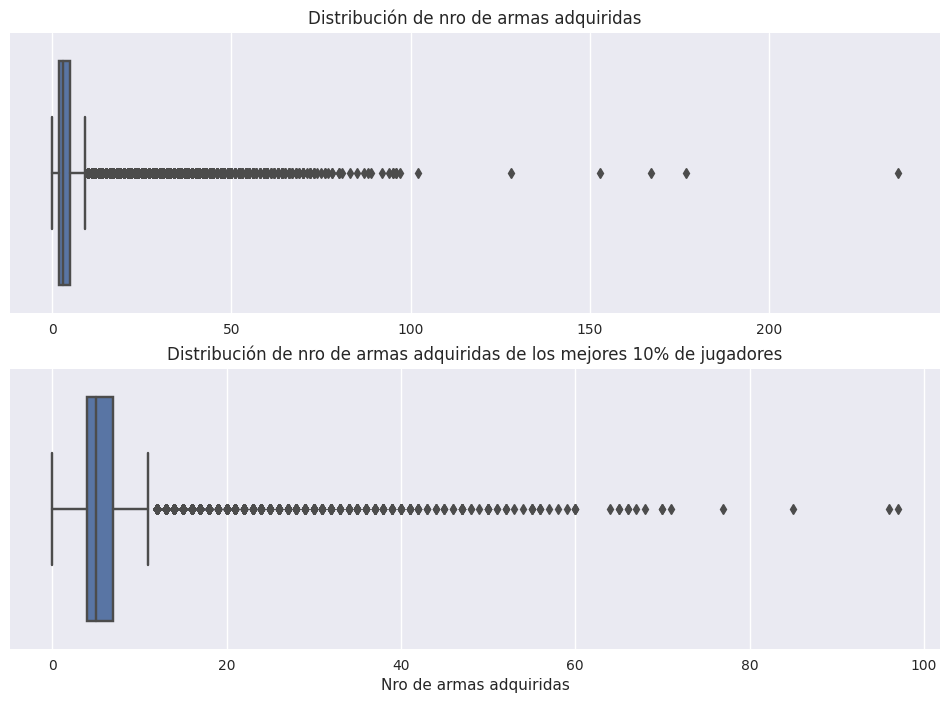

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,8))

sns.boxplot(data=PUBG, x='weaponsAcquired', ax=ax[0])
ax[0].set_title('Distribución de nro de armas adquiridas')
ax[0].set(xlabel=None)
sns.boxplot(data=top10, x='weaponsAcquired', ax=ax[1])
ax[1].set_title('Distribución de nro de armas adquiridas de los mejores 10% de jugadores')
ax[1].set(xlabel='Nro de armas adquiridas')
plt.show()

Observando la distribución de nro de armas adquiridas, vemos una gran cantidad de outliers tanto para el general, como para los mejores 10% de jugadores. Repetiremos las gráficas obviando estos, aunque ya se ve una tendencia de que los mejores 10% recogen mayor cantidad.

In [ ]:
# Definimos una función para determinar los límites que separan los bigotes de los outliers

def outliers(inp):
  perc_25 = np.percentile(inp, 25)
  perc_75 = np.percentile(inp, 75)
  IQR = perc_75 - perc_25
  LS = perc_75 + 1.5 * IQR
  LI = perc_25 - 1.5 * IQR
  return LI, LS

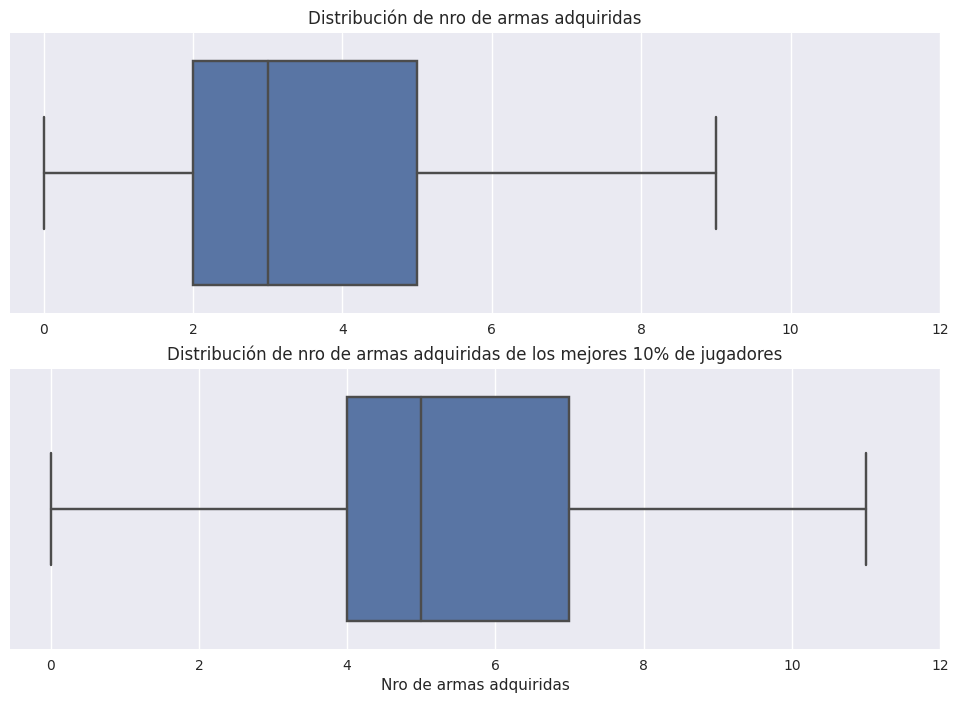

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,8))

LI, LS = outliers(PUBG['weaponsAcquired'])
sin_out = PUBG[(PUBG['weaponsAcquired'] > LI) & (PUBG['weaponsAcquired'] < LS)]
sns.boxplot(data=sin_out, x='weaponsAcquired', ax=ax[0])
ax[0].set_title('Distribución de nro de armas adquiridas')
ax[0].set(xlabel=None)
ax[0].set_xticks(np.arange(0, 14, 2))

LI, LS = outliers(top10['weaponsAcquired'])
sin_out10 = top10[(top10['weaponsAcquired'] > LI) & (top10['weaponsAcquired'] < LS)]
sns.boxplot(data=sin_out10, x='weaponsAcquired', ax=ax[1])
ax[1].set_title('Distribución de nro de armas adquiridas de los mejores 10% de jugadores')
ax[1].set(xlabel='Nro de armas adquiridas')
ax[1].set_xticks(np.arange(0, 14, 2))
plt.show()

Se confirma la tendencia notada en el gráfico anterior: los mejores 10% de jugadores tienden a adquirir mayor cantidad de armas que el general. Al ver las cantidades de los outliers, son números realmente elevados y probablemente se trate de gente que no este jugando seriamente la partida.

In [ ]:
cc = np.corrcoef(sin_out.weaponsAcquired, sin_out.winPlacePerc)
cc

array([[1.        , 0.63397554],
       [0.63397554, 1.        ]])

Si recalculamos el coeficiente de Pearson entre armas adquiridas y nuestra variable objetivo pero esta vez excluyendo a los outliers, vemos que este ha crecido levemente.

### Boosts

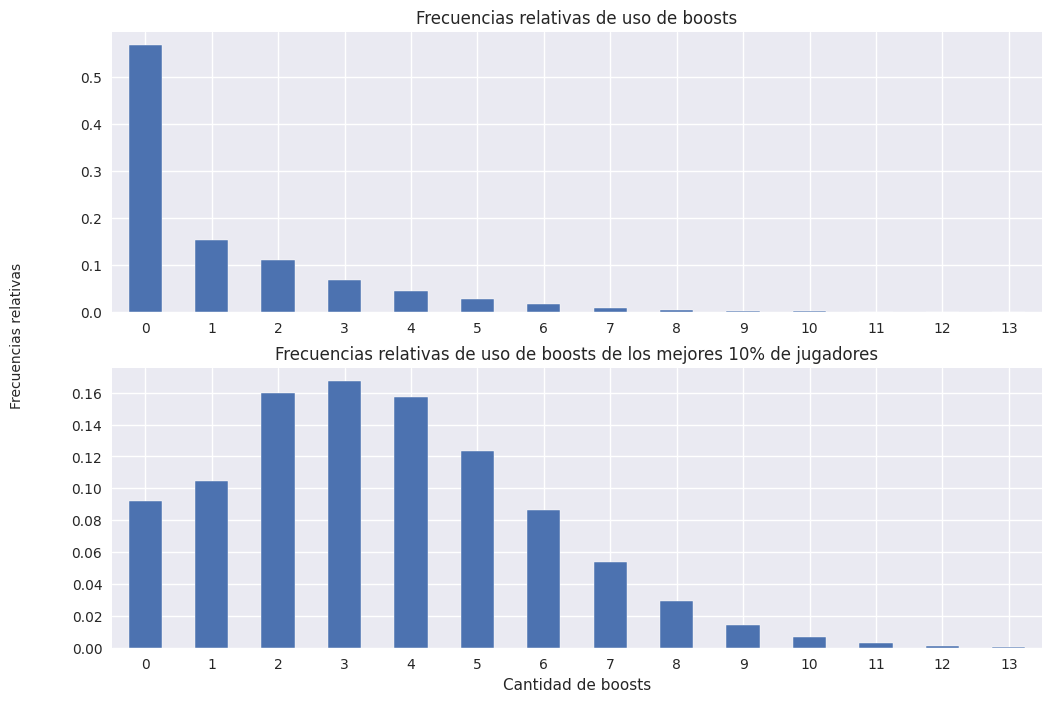


Cantidad media de boosts utilizados: 1.11
Cantidad media de boosts utilizados por los mejores 10% de jugadores: 3.56


In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,8))

(PUBG.boosts.value_counts()/len(PUBG.boosts)).sort_index().plot(kind='bar', 
                                                                title='Frecuencias relativas de uso de boosts', 
                                                                ax=ax[0])

(top10.boosts.value_counts()/len(top10.boosts)).sort_index().plot(kind='bar', 
                                                                  title='Frecuencias relativas de uso de boosts de los mejores 10% de jugadores', 
                                                                  ax=ax[1])
plt.xlabel('Cantidad de boosts')
fig.text(0.04, 0.5, 'Frecuencias relativas', va='center', rotation='vertical')
ax[0].tick_params(axis='x', rotation=0)
ax[0].set_xlim(None, 13.5)
ax[1].tick_params(axis='x', rotation=0)
ax[1].set_xlim(None, 13.5)
plt.show()

print('\nCantidad media de boosts utilizados: {:.2f}'.format(PUBG.boosts.mean()))
print('Cantidad media de boosts utilizados por los mejores 10% de jugadores: {:.2f}'.format(top10.boosts.mean()))

Nota: se han excluido de la gráfica cantidades mas elevadas de boosts ya que sus valores son mínimos en comparacion al grueso de los datos.

Comparando las frecuencias relativas, se observa que el 10% de mejores jugadores tiende a usar una mayor cantidad de boosts comparado al general, siendo la media de los primeros mas del triple. El uso de los mismos es muy comun por el final de la partida, con el mapa en una área pequeña y siendo el enfrentamiento con otros jugadores inminente.

### killplace

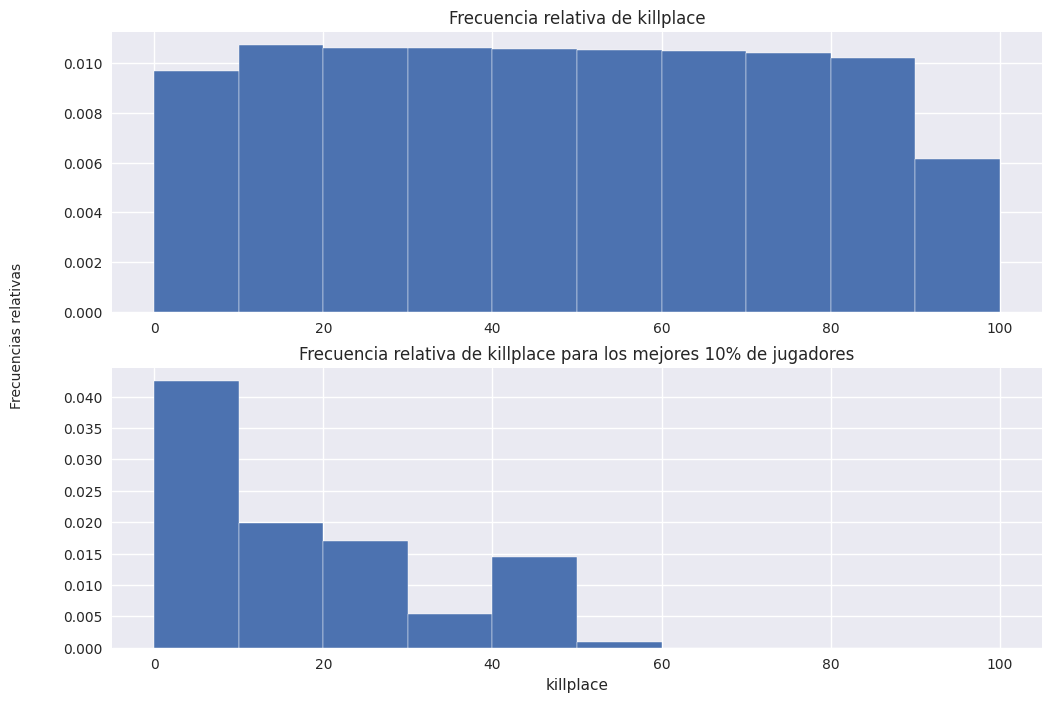


Mediana de killplace: 47.00
Mediana de killplace de los mejores 10% de jugadores: 12.00


In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,8))

Bins = np.arange(0, 110, 10)

PUBG.killPlace.plot(kind='hist', density=True, ax=ax[0], title='Frecuencia relativa de killplace', bins=Bins)
top10.killPlace.plot(kind='hist', density=True, ax=ax[1], title='Frecuencia relativa de killplace para los mejores 10% de jugadores', bins=Bins)
fig.text(0.04, 0.5, 'Frecuencias relativas', va='center', rotation='vertical')
ax[0].set(ylabel=None)
ax[1].set(ylabel=None)
plt.xlabel('killplace')
plt.show()

print('\nMediana de killplace: {:.2f}'.format(PUBG.killPlace.median()))
print('Mediana de killplace de los mejores 10% de jugadores: {:.2f}'.format(top10.killPlace.median()))

Recordemos que el killplace es un ranking dentro de la partida en cuanto a enemigos matados que va de 1 (mayor cantidad de asesinatos) a 100 (menor cantidad de asesinatos).

Si comparamos las frecuencias relativas del general vs los mejores 10% de jugadores, se observa que mientras los primeros tienen una distribución simil uniforme, los segundos poseen una asimetria hacia la derecha. Si nos concentramos en los valores de frecuencias relativas de este segundo grupo, vemos que estas resultan también mas elevadas. Todo esto resulta bastante lógico ya que se supone que los jugadores mas habilidosos tendrán mayor cantidad de asesinatos (menor killplace) y tenderán a quedar mejor rankeados en la partida (mayor winPlacePerc).

Utilizamos las medianas para tener una comparación numérica, y observamos que la correspondiente al 10% de mejores jugadores es mucho menor.

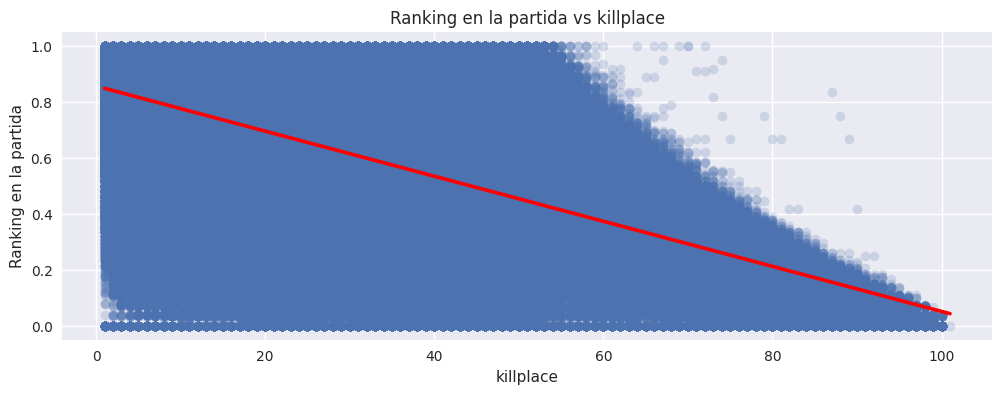

In [ ]:
plt.figure(figsize=(12, 4))
sns.regplot(data=PUBG, x='killPlace', y='winPlacePerc', 
            scatter_kws={'alpha':.2}, 
            line_kws={"color": "red"})
plt.xlabel('killplace')
plt.ylabel('Ranking en la partida')
plt.title('Ranking en la partida vs killplace')
plt.show()

Aqui puede observarse la correlacion negativa previamente indicada.

### Distancia recorrida a pie

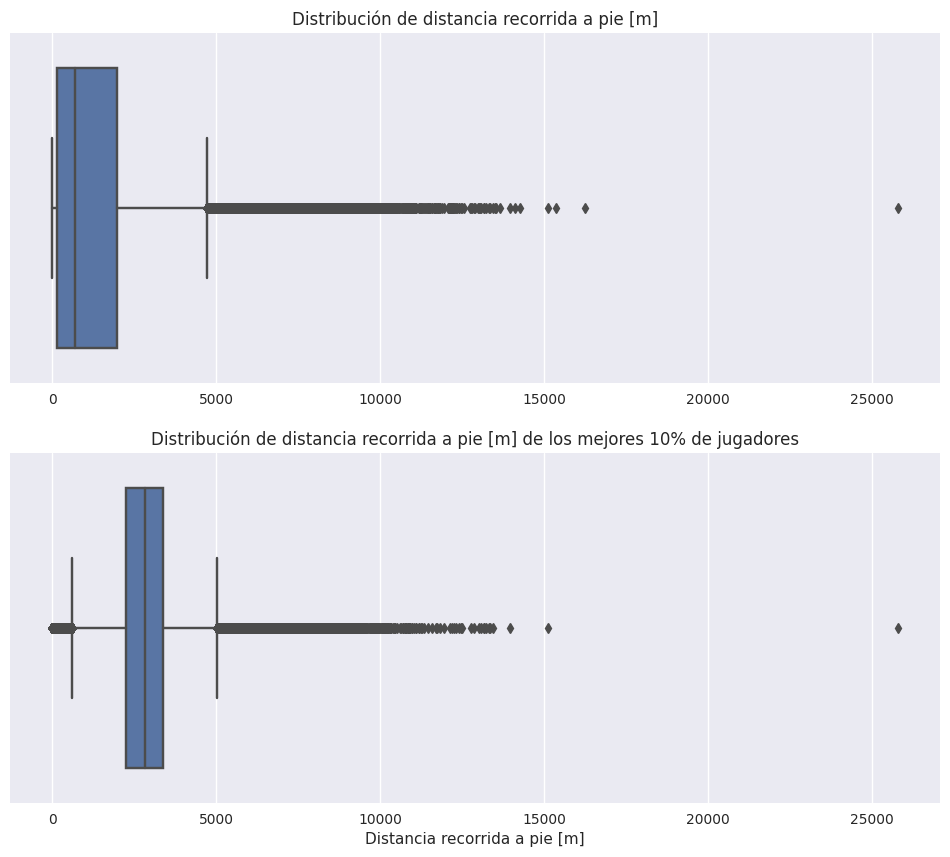

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,10))

sns.boxplot(data=PUBG, x='walkDistance', ax=ax[0])
ax[0].set_title('Distribución de distancia recorrida a pie [m]')
ax[0].set(xlabel=None)
sns.boxplot(data=top10, x='walkDistance', ax=ax[1])
ax[1].set_title('Distribución de distancia recorrida a pie [m] de los mejores 10% de jugadores')
ax[1].set(xlabel='Distancia recorrida a pie [m]')
plt.show()

La distancia recorrida a pie es la variable que mayor influencia posee en el resultado de nuestra variable objetivo. Su influencia puede verse en el tercer gráfico de esta notebook.

Al igual que en casos anteriores, se observan una gran cantidad de outliers tanto para el general, como para los mejores 10% de jugadores. Repetiremos las gráficas sin estos, aunque ya puede observarse como tendencia que el último grupo tiende a recorrer mayor distancia ya sea por estrategia de reposicionamiento, o realizando pequeños movimientos constantes para evadir francotiradores.

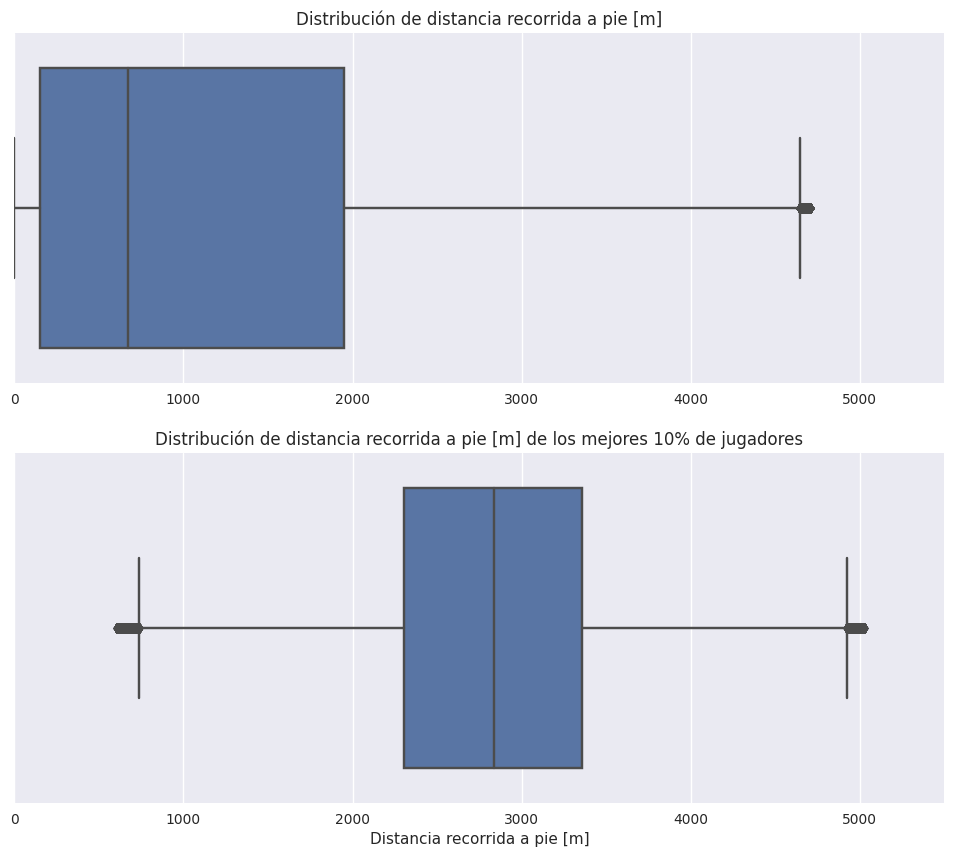

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,10))

LI, LS = outliers(PUBG['walkDistance'])
dist_sin_out = PUBG[(PUBG['walkDistance'] > LI) & (PUBG['walkDistance'] < LS)]
sns.boxplot(data=dist_sin_out, x='walkDistance', ax=ax[0])
ax[0].set_title('Distribución de distancia recorrida a pie [m]')
ax[0].set(xlabel=None)
ax[0].set_xticks(np.arange(0, 6000, 1000))
ax[0].set_xlim(0, 5500)

LI, LS = outliers(top10['walkDistance'])
dist_sin_out10 = top10[(top10['walkDistance'] > LI) & (top10['walkDistance'] < LS)]
sns.boxplot(data=dist_sin_out10, x='walkDistance', ax=ax[1])
ax[1].set_title('Distribución de distancia recorrida a pie [m] de los mejores 10% de jugadores')
ax[1].set(xlabel='Distancia recorrida a pie [m]')
ax[1].set_xticks(np.arange(0, 6000, 1000))
ax[1].set_xlim(0, 5500)
plt.show()

Al eliminar los outliers anteriores, aparecen nuevos; de todas maneras las gráficas ya son visibles con mayor facilidad. Se confirma la tendencia de que los mejores 10% de jugadores tienden a recorrer mayores distancias.

## Regression tree

Se aplicará ahora el modelo de árbol de decisión de regresión y se evaluaran las métricas obtenidas.

In [ ]:
PUBG = PUBG[(PUBG['weaponsAcquired'] <= 11) & (PUBG['walkDistance'] <= 5000) & (PUBG['boosts'] <= 13)]
# Se detectaron una importante cantidad de outliers en estas 3 variables, por lo cual nos concentraremos en las pertenecientes al bulto de datos

In [ ]:
X = PUBG.drop(labels=["winPlacePerc"], axis=1)
X.shape
# Eliminamos la variable objetivo de las independientes

(4404829, 25)

In [ ]:
y = PUBG["winPlacePerc"]
y.shape
# Variable objetivo

(4404829,)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
tree = DecisionTreeRegressor(random_state=4)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
# Se realiza el entrenamiento con 80% de la data, y se deja 20% para test

In [ ]:
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2: ", r2_score(y_test, y_pred))

MAE:  0.08057913869547746
MSE:  0.01328924893242569
RMSE:  0.11527900473384427
R2:  0.8587025297633653


El R2 se ubica alrededor del 0.85, lo que significa que el 85% de los datos es correctamente representado por el modelo. El RMSE es levemente superior al MAE, lo cual indica la presencia de algunos outliers. El modelo parece ser bastante preciso en sus predicciones y no se observa una situación de overfitting ni underfitting; esto puede deberse mas que nada a lo acotado de la variable objetivo (la misma es un percentil que va de 0 a 1). También ayuda el hecho de que nuestro dataset es bastante grande (mayor a 4M de filas) y se filtraron outliers correspondientes a 3 variables halladas ('weaponsAcquired', 'walkDistance' y 'boosts').